# Special playground for the workshop: 3D Quantitative Visualization of Fluorescently Labeled Cells (8am to 6pm Oct 1, 2019)	

This notebook contains the workflow for the example image provided in the workshop.

----------------------------------------

Key steps of the workflows:

* Min-max intensity normalization / Auto-contrast
* 3D Gaussian smoothing 
* 2D filament filter 
* Size thresholding

In [1]:
#==========
# CELL II.1
#==========

import os
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)

## Loading the data

In [2]:
#==========
# CELL II.2
#==========

FILE_PATH = ''

FILE_NAME = "tutorial-mitochondria_1_V1.ome.tif"

reader = AICSImage(FILE_NAME) # AICSImage(os.path.join(FILE_PATH,FILE_NAME)) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

(1, 1, 65, 7, 624, 924)


## Preview of the image

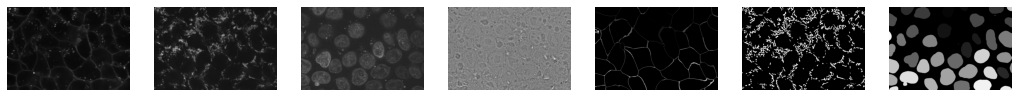

In [3]:
#==========
# CELL II.3
#==========

N_CHANNELS = IMG.shape[3]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,0,MID_SLICE, channel,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,0,:,:], cmap=plt.cm.gray)

In [4]:
#==========
# CELL II.4
#==========

#####################
structure_channel = 1
#####################

struct_img0 = IMG[0,0,:, structure_channel,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [14]:
view(IMG[0,0,:, structure_channel,:,:])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [15]:
import numpy as np

In [16]:
im = IMG[0,0,:,0:2,:,:]

In [17]:
im.shape

(65, 2, 624, 924)

In [18]:
im2 = np.transpose(im, (0,2,3,1))

In [23]:
view(im2)

TemplateTypeError: itk.Image is not wrapped for input type `itk.F, int`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.Image.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.Image[itk.RGBPixel[itk.UC], int].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,2]
itk.FixedArray[itk.D,2]
itk.Offset[2]
itk.SymmetricSecondRankTensor[itk.D,2]
itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,3]
itk.FixedArray[itk.D,3]
itk.Offset[3]
itk.SymmetricSecondRankTensor[itk.D,3]
itk.Vector[itk.F,1]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.Vector[itk.F,1]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.NormalBandNode[itk.Image[itk.F,2]]
itk.NormalBandNode[itk.Image[itk.D,2]]
itk.NormalBandNode[itk.Image[itk.F,3]]
itk.NormalBandNode[itk.Image[itk.D,3]]


In [20]:
im2.shape

(65, 624, 924, 2)

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * `intensity_scaling_param = [3.5, 15]`


* **Smoothing** 

    * `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed. 

In [7]:
#==========
# CELL II.5
#==========

# Parameters
intensity_scaling_param = [3.5, 60]
gaussian_smoothing_sigma = 1

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

In [8]:
#==========
# CELL II.6
#==========

view(single_fluorescent_view(structure_img_smooth))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = ` 

In [ ]:
#==========
# CELL II.7
#==========

from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

### Step 2: Core Algorithm

#### apply 2d filament filter 

* Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
    * `scale_x` is set based on the estimated width of your target curvilinear shape. For example, if visually the width of the objects is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have objects of very different sizes.  
    * `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf fatter segmentation, while larger `cutoff_x` could be less permisive and yield less objects and slimmer segmentation. 


* `f2_param = [[1.5, 0.16]]`

In [9]:
#===========
# CELL III.1
#===========

f2_param = [[1.5, 0.16]]

bw = filament_2d_wrapper(structure_img_smooth, f2_param)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [10]:
#===========
# CELL III.2
#===========

viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side

You can select an ROI in above visualization; otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

In [ ]:
#===========
# CELL III.3
#===========

view(seg_fluo_side_by_side(struct_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

##### Is the segmentation satisfactory? Here are some possible criteria:

--------------------------
* Is there any object should be detected but not? Try to reduce `cutoff_x`
* Is there any object should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented width of the objects is fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any object that should be solid but segmented as fragmented pieces? Try to increase `scale_x`
* Are you observing objects with very different width? Try multiple sets of `scale_x` and `cutoff_x` 
--------------------------

#### Step 3: Post-Processing 

In [11]:
#===========
# CELL III.4
#===========

minArea = 5

seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [12]:
#===========
# CELL III.5
#===========

viewer_final = view(segmentation_quick_view(seg))
viewer_final

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

### You can also focus your inspection on a small ROI

You can select an ROI in above visualization; otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

In [ ]:
#===========
# CELL III.5
#===========

view(seg_fluo_side_by_side(struct_img, seg, roi=['ROI',viewer_final.roi_slice()]))

### You may also physically save the segmentation results into a ome.tif file

In [ ]:
#===========
# CELL III.6
#===========

seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter(os.path.join(FILE_PATH,'seg.ome.tif'))
writer.save(out)

## Feature Extraction

First we import necessary packages and perform connected components labeling.

In [ ]:
#==========
# CELL IV.1
#==========

import pandas as pd
from skimage import measure
import matplotlib.pyplot as plt

seg_labeled = measure.label(seg)

Now we loop over each connected component and we count how many pixels it contains. Everything is stored as a dataframe. The first 5 lines of the resulting dataframe is shown after the computation is done.

In [ ]:
#==========
# CELL IV.2
#==========

df = []
for cc in range(1,seg_labeled.max()+1):
        df.append({
            "label": cc,
            "volume": (seg_labeled==cc).sum()
        })
df = pd.DataFrame(df)
df.head()

### Total volume (in pixels):

In [ ]:
#==========
# CELL IV.3
#==========

df.volume.sum()

### Number of connected components:

In [ ]:
#==========
# CELL IV.4
#==========

df.shape[0]

### Average volume per connected component (in pixels):

In [ ]:
#==========
# CELL IV.5
#==========

df.volume.mean()

### Std of volume:

In [ ]:
#==========
# CELL IV.6
#==========

df.volume.std()